<a href="https://colab.research.google.com/github/yutan0565/Wake-up-Word_tensorflow2/blob/main/Wake_up_word_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install python_speech_features
# !pip install playsound
# !pip install -q tensorflow-model-optimization
# !pip install pyaudio

  ERROR: Command errored out with exit status 1:

  Running setup.py clean for pyaudio
Failed to build pyaudio
    Running setup.py install for pyaudio: started
    Running setup.py install for pyaudio: finished with status 'error'



   command: 'C:\Users\yutan\anaconda3\envs\tensorflow\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\yutan\\AppData\\Local\\Temp\\pip-install-rkymhai7\\pyaudio_3e6424cbd9254abf8e2d3cc9b7c6c405\\setup.py'"'"'; __file__='"'"'C:\\Users\\yutan\\AppData\\Local\\Temp\\pip-install-rkymhai7\\pyaudio_3e6424cbd9254abf8e2d3cc9b7c6c405\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\yutan\AppData\Local\Temp\pip-wheel-7y4_g2u6'
       cwd: C:\Users\yutan\AppData\Local\Temp\pip-install-rkymhai7\pyaudio_3e6424cbd9254abf8e2d3cc9b7c6c405\
  Complete output (9 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.7
  copying src\pyaudio.py -> build\lib.

# 데이터 학습 준비

In [112]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
from playsound import playsound

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
import tensorflow_model_optimization as tfmot
from tensorflow import lite

#base_path = "/content/drive/MyDrive/"
base_path = "./"

In [154]:
# MFCC 추출 해주기
# https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=sooftware&logNo=221661644808 참고

# frame 개수를 보여줌
num_mfcc = 60
def get_librosa_mfcc(filepath):
  samplie_rate = 16000
  sig, sr = librosa.core.load(filepath, samplie_rate)

  # log mell 찾아 보기
  # 120 만큼은 겹치게 된다.
  mfccs = librosa.feature.mfcc(y = sig, sr = sr, hop_length =128, n_mfcc = num_mfcc, n_fft = 512 )
  return mfccs

# 뭐가 바뀌는 건지 찾아봐야함
len_mfcc = 120


# n_mfcc : 음성데이터를 어느 단위로 쪼갤지 (사람은 20 ~ 40 ms 까지는 음소가 바뀌지 못함 - 말 자르는 가장 작은 단위 == frame_size
# n_fft : frame의 length = window size,   잘린 음석이 n_ftt보다 작으면 0으로 Padding 해줌, 
   #n_fft는 winddow size보다 크거나 같아야함
   # n_ftt = 8000 * 0.040 = 320
# hop_legth : window 얼마 만큼씩 움질일 것인가

  # n_mfcc = 40
  # hop_length = 200  # 8000 * 0.040
  # N_FFT = 320    # 8000 * 0.040

# 이거 기준으로 나눈 다음에 Mel값을 뽑아서 Feature로 사용하게 된다.  (  50%는 겹치게 분할을 진행)
# 각각의 frame에 대해서 Hamming Window 적용해서 연속성 맞춰주기 - Default 설정임
# 각 프레임에 대하여 Fourier Transform 적용해서(FFT) 주파서 성분 알아내기
# Mel Filter Banb(삶귀처럼, 주파수 증가할수록 큰 삼각형 filter가 생각다고 생각하기)
# 여기까지하면 Mel-Spectrogram Feature가 추출된다.

# Mel-Spectrogram 을 압축해서 표현해주는 DCT 연산 수행 -> Discrete Cosine Transform


In [155]:
# 데이터가 저장되어 있는 경로 ( class 별로 묶여 있는 곳)
dataset_path = base_path + 'custum_dataset'
print(dataset_path)

# 폴더 안에 들어 있는 폴더명(class 이름 확인)
for name in listdir(dataset_path): 
  if isdir( "/".join( [dataset_path,name ])) :  # 폴더가 존재 한다면
    print(name)

# 폴더명 = target ,  target이 들어가 있는 list 생성
target_list = [ name for name in listdir(dataset_path) if isdir("/".join( [dataset_path,name ]))]
target_list.remove('_background_noise_')  # 배경음 제거 해주기
target_list.remove('.ipynb_checkpoints')
print(target_list)

# filname, 을 쪽 모아서,
filenames = []
y = []
for index, target in enumerate(target_list):
    print('/'.join([dataset_path, target]))  # class 에 맞는 폴더 이름 넣어주기
    filenames.append(listdir('/'.join([dataset_path, target])))
    y.append(np.ones(len(filenames[index])) * index) 

# 하나로 쭉 나열 하기
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

# file 모아둔거 한번 섞어 주기
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

# train, valid, test 나눠 주기
val_ratio = 0.3
test_ratio = 0.4

val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]



./custum_dataset
.ipynb_checkpoints
hi_yutan
no
_background_noise_
['hi_yutan', 'no']
./custum_dataset/hi_yutan
./custum_dataset/no


In [156]:
print(len(filenames_val), len(y_orig_val))
print(len(filenames_test), len(y_orig_test))
print(len(filenames_train), len(y_orig_train))


23 23
30 30
24 24


In [157]:
# 지금 내가 가지고 있는 것을 다 변환 했을때  동일한 크기의 mfcc 파일이 나오는가, 이상한거는 버려주기
prob_cnt = 0  
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], filename)
    
    # Create MFCCs
    mfccs = get_librosa_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:    # 지금은 40으로 설정되어 있음, ///  길이가 부족하면 나중에 버려야함
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Dropped: 0 (60, 214)
Dropped: 1 (60, 305)
Dropped: 2 (60, 305)
Dropped: 3 (60, 305)
Dropped: 4 (60, 214)
Dropped: 5 (60, 214)
Dropped: 6 (60, 305)
Dropped: 7 (60, 214)
Dropped: 8 (60, 302)
Dropped: 9 (60, 385)
Dropped: 10 (60, 249)
Dropped: 11 (60, 249)
Dropped: 12 (60, 385)
Dropped: 13 (60, 305)
Dropped: 14 (60, 259)
Dropped: 15 (60, 249)
Dropped: 16 (60, 281)
Dropped: 17 (60, 214)
Dropped: 18 (60, 302)
Dropped: 19 (60, 214)
Dropped: 20 (60, 249)
Dropped: 21 (60, 249)
Dropped: 22 (60, 214)
Dropped: 23 (60, 302)


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


MFCCs: [[-9.0627393e+02 -8.7097339e+02 -8.4589380e+02 ... -6.2569849e+02
  -6.6290808e+02 -7.1567334e+02]
 [ 2.0524021e+01  4.6292393e+01  5.9618313e+01 ... -6.9311783e+01
  -4.9545410e+01 -3.4101063e+01]
 [ 1.4289994e+01  1.3205786e+01  7.6923428e+00 ...  6.0647152e+01
   6.7233948e+01  4.1928101e+01]
 ...
 [ 5.1398480e-01 -2.0517735e+00 -1.1776249e+00 ...  6.4010115e+00
  -1.7707838e+00 -1.6799514e+00]
 [-9.4373965e-01 -4.8850346e-01 -1.8940315e-01 ... -3.9248614e+00
   1.4449236e+00  1.1289749e+00]
 [-1.5471942e+00  5.6208634e-01 -1.6007165e+00 ... -1.4545615e+00
  -2.5914311e-01  1.1524931e+00]]


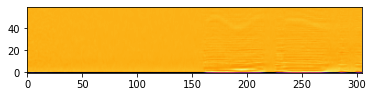

In [158]:
# 내가 확인 할 부분
idx = 1

# Create path from given filename and target item
path = '/'.join([dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx]])

# mfcc 만들기
mfccs = get_librosa_mfcc(path)
print("MFCCs:", mfccs)

# MFCC 그림으로 보기
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# 소리 확인
# print(target_list[int(y_orig_train[idx])])
# print(path)
# playsound(path)

In [159]:
# 학습 하기 전에 미리 모든 소리에 대해서 feature 추출해서 준비 해두는 단계, inpu을 맞추려고 
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = "/".join([dataset_path, target_list[int(in_y[index])], 
                    filename])
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = get_librosa_mfcc(path)
        print(mfccs.shape)

        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [160]:
print(len(y_train))
print(len(y_val))
print(len(y_test))

0
0
0


In [161]:
x_train, y_train, prob_train = extract_features(filenames_train, y_orig_train)
x_val, y_val, prob_val = extract_features(filenames_val, y_orig_val)
x_test, y_test, prob_test = extract_features(filenames_test, y_orig_test)


print("Train 잃은거{}".format(prob_train / len(y_orig_val)))
print("Valid 잃은거{}".format(prob_val / len(y_orig_val)))
print("Test 잃은거{}".format(prob_test / len(y_orig_test)))

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


(60, 214)
Dropped: 0 (60, 214)
(60, 305)
Dropped: 1 (60, 305)
(60, 305)
Dropped: 2 (60, 305)
(60, 305)
Dropped: 3 (60, 305)
(60, 214)
Dropped: 4 (60, 214)
(60, 214)
Dropped: 5 (60, 214)
(60, 305)
Dropped: 6 (60, 305)
(60, 214)
Dropped: 7 (60, 214)
(60, 302)
Dropped: 8 (60, 302)
(60, 385)
Dropped: 9 (60, 385)
(60, 249)
Dropped: 10 (60, 249)
(60, 249)
Dropped: 11 (60, 249)
(60, 385)
Dropped: 12 (60, 385)
(60, 305)
Dropped: 13 (60, 305)
(60, 259)
Dropped: 14 (60, 259)
(60, 249)
Dropped: 15 (60, 249)
(60, 281)
Dropped: 16 (60, 281)
(60, 214)
Dropped: 17 (60, 214)
(60, 302)
Dropped: 18 (60, 302)
(60, 214)
Dropped: 19 (60, 214)
(60, 249)
Dropped: 20 (60, 249)
(60, 249)
Dropped: 21 (60, 249)
(60, 214)
Dropped: 22 (60, 214)
(60, 302)
Dropped: 23 (60, 302)
(60, 294)
Dropped: 0 (60, 294)
(60, 214)
Dropped: 1 (60, 214)
(60, 281)
Dropped: 2 (60, 281)
(60, 385)
Dropped: 3 (60, 385)
(60, 305)
Dropped: 4 (60, 305)
(60, 294)
Dropped: 5 (60, 294)
(60, 249)
Dropped: 6 (60, 249)
(60, 299)
Dropped: 7 (60,

In [162]:
# 학습에 사용할 모든 - MFCC 까지 모두 진행한 정보들
#저장 할 곳
np.savez("./mfcc_set.npz", 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

# 모델 학습

In [143]:
# 나중에 저장할 모델 - 2진 분류
model_filename = 'hi_yutan_original_model.h5'
wake_word = 'hi_yutan'
feature_sets = np.load( base_path + "mfcc_set.npz")

# 저장되어 있는 mfcc feature 들 불러 오기
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [144]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(0,)
(0,)
(0,)


In [145]:
# 내가 수행 하고 싶은 "기동어" 설정
# index (나는 하나니까 0) 이면, True 또는 False 반환 해주기 - 1아니면 0 ]
wake_word_index = target_list.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')
print(wake_word_index)

0


In [146]:
# CNN 에 넣기 이전에 Channel을 1로 만들어주기

x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

sample_shape = x_test.shape[1:]
print(sample_shape)

IndexError: tuple index out of range

In [ ]:
# 모델 Conv-layer 
conv_layer = keras.Sequential([
                             layers.Conv2D(32, (2,2), activation = 'relu', input_shape = sample_shape),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Conv2D(32, (2, 2), activation='relu'),
                             layers.MaxPooling2D(pool_size=(2, 2)),
                             layers.Conv2D(64, (2, 2), activation='relu'),
                             layers.MaxPooling2D(pool_size=(2, 2))
                             ])
# FC layer는 다른거 사용   --  Class 10 개 분류
fc_layer = keras.Sequential([
                             layers.Flatten(),
                             layers.Dense(64, activation = 'relu'),
                             layers.Dropout(0.5),
                             layers.Dense(1, activation = "sigmoid")
                             ])

model = keras.Sequential([conv_layer,
                          fc_layer
                          ])
model.summary()

In [ ]:
# Callback 함수 지정 해주기      학습하는 동안 설정해줄것
early_stop = EarlyStopping(patience=30) 
mc = ModelCheckpoint(base_path + "best_model/wake_up_word_model", 
                     save_best_only=True,
                     monitor = 'val_loss',
                     verbose = 1,
                     mode = 'min') 
reduce_lr  = ReduceLROnPlateau(monitor = 'val_loss',
                               factor=0.5, 
                               patience=5
                               ) 

#optimizer 조정 해주기
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
# optimizer, loss 함수를 정의하고,  학습 준비를 한다,  metrics 는 어떤 일이 발생하는지 보여줄 것들
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# 한번에 몇개의 데이터 학습하고 가중치 갱신할지 
history = model.fit(x_train, y_train,
          epochs=100,
          verbose=1,
          batch_size=32,
          #validation_split = 0.1
          validation_data = (x_val, y_val),
          callbacks = [early_stop, reduce_lr , mc]
          )

In [ ]:
# 학습 과정 점검 하기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

In [ ]:
# 학습한거에서 test 어떻게 나오는지 확인 해보기
model = tf.keras.models.load_model(base_path + 'best_model/wake_up_word_model')
for i in range(0, 1):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

In [ ]:
model.evaluate(x=x_test, y=y_test)

In [ ]:
print(x_test, y_test)
print(x_test.shape, y_test.shape)


# tflite 변환 해주기

In [ ]:
tflite_filename = 'wake_word_hi_yutan_lite.tflite'

model = tf.keras.models.load_model(base_path + 'best_model/wake_up_word_model')
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(tflite_filename, 'wb').write(tflite_model)

# 추론 과정

In [81]:
# 기본 형태
import pyaudio
import numpy as np
 
CHUNK = 2**10  # 음성 데이터 불러올때, 한번에 몇개의 정수를 불러올지
RATE = 44100   # 음성 데이터의 sampleing rate , mfcc 에 나오는 거라 다른거니까 구분 해두기

# 음성 데이터 스트리을 여는 코드
"""
foramt : 비트 깊이를 설정 ,   여기서는 16bit가 된다
input : 우리가 지금 열려고 하는 것이기 떄문에 True
frames_per_buffer : 한번에 몇개의 정수를 불러올지
input_device_index : 원하는 입력 장치의 번호 (이거 없으면 자동으로 설정 해준다..)
"""
p=pyaudio.PyAudio()
stream=p.open(format=pyaudio.paInt16,channels=1,rate=RATE,input=True,
              frames_per_buffer=CHUNK,input_device_index=2)
 
# 음성 데이터를 입력받아 출력하는 소스
while(True):
    data = np.fromstring(stream.read(CHUNK),dtype=np.int16)
    print(int(np.average(np.abs(data))))
 
stream.stop_stream()
stream.close()
p.terminate()


  Using cached PyAudio-0.2.11.tar.gz (37 kB)
  Running setup.py clean for pyaudio
Failed to build pyaudio
    Running setup.py install for pyaudio: started
    Running setup.py install for pyaudio: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\yutan\anaconda3\envs\tensorflow\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\yutan\\AppData\\Local\\Temp\\pip-install-zgpxs60p\\pyaudio_880cf6d2742844508cfcbcf7ff1b29e5\\setup.py'"'"'; __file__='"'"'C:\\Users\\yutan\\AppData\\Local\\Temp\\pip-install-zgpxs60p\\pyaudio_880cf6d2742844508cfcbcf7ff1b29e5\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\yutan\AppData\Local\Temp\pip-wheel-lophh8k5'
       cwd: C:\Users\yutan\AppData\Local\Temp\pip-install-zgpxs60p\pyaudio_880cf6d2742844508cfcbcf7ff1b29e5\
  Complete output (9 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-

ModuleNotFoundError: No module named 'pyaudio'

In [80]:
"""
Connect a resistor and LED to board pin 8 and run this script.
Whenever you say "stop", the LED should flash briefly
"""

import sounddevice as sd
import numpy as np
import scipy.signal
import timeit
import python_speech_features
import RPi.GPIO as GPIO

from tflite_runtime.interpreter import Interpreter

# Parameters
debug_time = 1
debug_acc = 0
led_pin = 8
word_threshold = 0.5
rec_duration = 0.5 # 기동어 말 평균 길이로 하면 될듯 함
window_stride = 0.5 # 이거는 유지 해주기
sample_rate = 48000
resample_rate = 8000
num_channels = 1
num_mfcc = 40
model_path = base_path + 'wake_word_hi_yutan_lite.tflite'

# Sliding window
window = np.zeros(int(rec_duration * resample_rate) * 2)

# GPIO 
GPIO.setwarnings(False)
GPIO.setmode(GPIO.BOARD)
GPIO.setup(8, GPIO.OUT, initial=GPIO.LOW)

# Load model (interpreter)
interpreter = Interpreter(model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

# Decimate (filter and downsample)
def decimate(signal, old_fs, new_fs):
    
    # Check to make sure we're downsampling
    if new_fs > old_fs:
        print("Error: target sample rate higher than original")
        return signal, old_fs
    
    # We can only downsample by an integer factor
    dec_factor = old_fs / new_fs
    if not dec_factor.is_integer():
        print("Error: can only decimate by integer factor")
        return signal, old_fs

    # Do decimation
    resampled_signal = scipy.signal.decimate(signal, int(dec_factor))

    return resampled_signal, new_fs

# This gets called every 0.5 seconds
def sd_callback(rec, frames, time, status):

    GPIO.output(led_pin, GPIO.LOW)

    # Start timing for testing
    start = timeit.default_timer()
    
    # Notify if errors
    if status:
        print('Error:', status)
    
    # Remove 2nd dimension from recording sample
    rec = np.squeeze(rec)
    
    # Resample
    rec, new_fs = decimate(rec, sample_rate, resample_rate)
    
    # Save recording onto sliding window
    window[:len(window)//2] = window[len(window)//2:]
    window[len(window)//2:] = rec

    # Compute features
    mfccs = python_speech_features.base.mfcc(window, 
                                        samplerate=new_fs,
                                        winlen=0.256,
                                        winstep=0.050,
                                        numcep=num_mfcc,
                                        nfilt=26,
                                        nfft=2048,
                                        preemph=0.0,
                                        ceplifter=0,
                                        appendEnergy=False,
                                        winfunc=np.hanning)
    mfccs = mfccs.transpose()

    # Make prediction from model
    in_tensor = np.float32(mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1))
    interpreter.set_tensor(input_details[0]['index'], in_tensor)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    val = output_data[0][0]
    if val > word_threshold:
        print('stop')
        GPIO.output(led_pin, GPIO.HIGH)

    if debug_acc:
        print(val)
    
    if debug_time:
        print(timeit.default_timer() - start)

# Start streaming from microphone
with sd.InputStream(channels=num_channels,
                    samplerate=sample_rate,
                    blocksize=int(sample_rate * rec_duration),  # 1초에 프레임 * 녹화 하는 기간
                    callback=sd_callback):
    while True:
        pass

ModuleNotFoundError: No module named 'sounddevice'